## TopK Reinforce Off Policy Correction

### (TopK is here!)

The following code contains an implementation of the REINFORCE algorithm, **LSTM state encoder, and Noise Contrastive Estimation**. Look for these in other notebooks.

Also, I am not google staff, and unlike the paper authors, I cannot have online feedback concerning the recommendations.

**I use actor-critic for reward assigning.** In a real-world scenario that would be done through interactive user feedback, but here I use a neural network (critic) that aims to emulate it.

In [1]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch_optimizer as optim

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 10
n_epochs   = 100
plot_every = 30
num_items    = 5000 # n items to recommend. Can be adjusted for your vram 
# --- 

tqdm.pandas()


from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [3]:
def embed_batch(batch, item_embeddings_tensor, *args, **kwargs):
    return recnn.data.batch_contstate_discaction(batch, item_embeddings_tensor,
                                                 frame_size=frame_size, num_items=num_items)

    
def prepare_dataset(**kwargs):
    recnn.data.build_data_pipeline([recnn.data.truncate_dataset,
                                    recnn.data.prepare_dataset], reduce_items_to=num_items, **kwargs)
    
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
env = recnn.data.env.FrameEnv('../../data/embeddings/ml20_pca128.pkl',
                              '../../data/ml-20m/ratings.csv', frame_size, batch_size,
                              embed_batch=embed_batch, prepare_dataset=prepare_dataset,
                              num_workers = 0)

action space is reduced to 26744 - 21744 = 5000


In [4]:
class Beta(nn.Module):
    def __init__(self):
        super(Beta, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1290, num_items),
            nn.Softmax()
        )
        self.optim = optim.RAdam(self.net.parameters(), lr=1e-5, weight_decay=1e-5)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, state, action):
        
        predicted_action = self.net(state)
        
        loss = self.criterion(predicted_action, action.argmax(1))
        
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        
        return predicted_action.detach()

In [5]:
beta_net   = Beta().to(cuda)
value_net  = recnn.nn.Critic(1290, num_items, 2048, 54e-2).to(cuda)
policy_net = recnn.nn.DiscreteActor(1290, num_items, 2048).to(cuda)
# as miracle24 has suggested https://github.com/awarebayes/RecNN/issues/7
# you can enable this to be more like the paper authors meant it to
policy_net.action_source = {'pi': 'beta', 'beta': 'beta'}

reinforce = recnn.nn.Reinforce(policy_net, value_net)
reinforce = reinforce.to(cuda)

reinforce.writer = SummaryWriter(log_dir='../../runs')
plotter = recnn.utils.Plotter(reinforce.loss_layout, [['value', 'policy']],)

In [6]:
from recnn.nn import ChooseREINFORCE

def select_action_corr(state, action, K, writer, step, **kwargs):
    # note here I provide beta_net forward in the arguments
    return reinforce.nets['policy_net']._select_action_with_TopK_correction(state, beta_net.forward, action,
                                                                            K=K, writer=writer,
                                                                            step=step)

reinforce.nets['policy_net'].select_action = select_action_corr
reinforce.params['reinforce'] = ChooseREINFORCE(ChooseREINFORCE.reinforce_with_TopK_correction)
reinforce.params['K'] = 10

step 2430


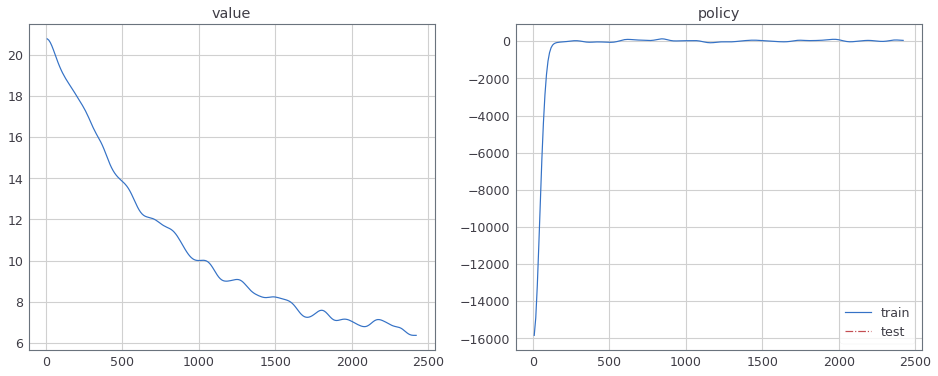

KeyboardInterrupt: 

In [7]:
from tqdm.auto import tqdm
for epoch in range(n_epochs):
    for batch in tqdm(env.train_dataloader):
        loss = reinforce.update(batch)
        reinforce.step()
        if loss:
            plotter.log_losses(loss)
        if reinforce._step % plot_every == 0:
            clear_output(True)
            print('step', reinforce._step)
            plotter.plot_loss()
        if reinforce._step > 1000:
            pass
            # assert False